In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import matplotlib.pyplot as plt

In [3]:
from argparse import Namespace
from pathlib import Path
import torch
from pytorch_lightning.trainer import Trainer, seed_everything
from pytorch_lightning.callbacks import EarlyStopping, ModelCheckpoint

from turboflow.dataloaders import TurboFlowDataModule
from turboflow.evaluation import compute_all_metrics

from turboflow.utils import phy_utils as phy
from turboflow.utils import torch_utils as tch

In [4]:
seed_everything(42, workers=True)

Global seed set to 42


42

In [5]:
# load dataset
data_dir = Path('/','home','dicarlo_d','Documents','Datasets','Turb2D.hdf5')
dm = TurboFlowDataModule(dataset='Turb2D', 
                         data_dir=data_dir,
                         batch_size=100000,
                         time_idx=33,
                         train_downsampling=8,
                         val_downsampling=8,
                         test_downsampling=1,
                         num_workers=1)
dm.setup()

In [7]:
# choose the hyperparams
hparams = {
    'name':'RFFNet',
    'mlp_layers_num': 5,
    'mlp_layers_dim': 256, 
    'mlp_last_actfn': 'tanh',
    'do_rff': True, 
    'rff_num': 1024, 
    'rff_scale': 10,
    'do_divfree': True,
    'lam_pde': 0,     # soft constr. grad(u,v)=0
    'lam_div': 0,     # spatial grad(u,v) = torch.autograd(u,v)
    'lam_reg': 0,     # offgrid L2 reg. on grad of the potential
    'lam_sfn': 0,     # offgrid L2 reg. on Sfun
    'lam_spec': 0,    # L2 diff on the spectrum
    'lam_grads':1,    # offrgid L2 reg. on grad and autograd
    'lam_weight': 0,  # L2 reg on the NN's weights
    'sfn_min_x': 0.00784314,
    'sfn_num_centers': 50,
    'sfn_num_increments':3,
    'sfn_patch_dim': 30
}

In [8]:
early_stop_callback = EarlyStopping(monitor='val_loss')
checkpoint_callback = ModelCheckpoint(
    monitor="val_loss",
    dirpath=".torch_checkpoints",
    filename="Turb2D-%s-{epoch:02d}-{val_loss:.2f}" % (hparams['name']),
    save_top_k=1,
    mode="min",
)

trainer = Trainer(gpus=1,
                  max_epochs=5000, 
                  log_every_n_steps=20,
                  check_val_every_n_epoch=20, 
                  callbacks=[early_stop_callback,
                             checkpoint_callback])

from turboflow.models.phyrff_hard import plDivFreeRFFNet
model = plDivFreeRFFNet(**vars(Namespace(**hparams)))

/home/dicarlo_d/Documents/Code/TurboSuperResultion/venv/lib/python3.8/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:446: UserWarning: Checkpoint directory .torch_checkpoints exists and is not empty.
  rank_zero_warn(f"Checkpoint directory {dirpath} exists and is not empty.")
GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs


In [11]:
grads_path = '/home/dicarlo_d/Documents/Code/TurboSuperResultion/notebooks/.torch_checkpoints/Turb2D-RFFNet-epoch=1019-val_loss=0.01-v1.ckpt'
no_grads_path = '/home/dicarlo_d/Documents/Code/TurboSuperResultion/notebooks/.torch_checkpoints/Turb2D-RFFNet-epoch=839-val_loss=0.00.ckpt'

model_grad = plDivFreeRFFNet.load_from_checkpoint(grads_path)
model_nograd = plDivFreeRFFNet.load_from_checkpoint(no_grads_path)

In [12]:
X_lr, y_lr = dm.val_dataset[:]
img_shape_lr = dm.val_dataset.img_shape[:2]
shape_lr = dm.val_dataset.img_shape

X_hr, y_hr = dm.test_dataset[:]
img_shape_hr = dm.test_dataset.img_shape[:2]
shape_hr = dm.test_dataset.img_shape

print(X_lr.shape, y_lr.shape)
print(X_hr.shape, y_hr.shape)

y_hat_lr_nograd, P_hat_lr_nograd = model_nograd(X_lr)
y_hat_hr_nograd, P_hat_hr_nograd = model_nograd(X_hr)

y_hat_lr_grad, P_hat_lr_grad = model_grad(X_lr)
y_hat_hr_grad, P_hat_hr_grad = model_grad(X_hr)

torch.Size([1024, 2]) torch.Size([1024, 2])
torch.Size([65536, 2]) torch.Size([65536, 2])


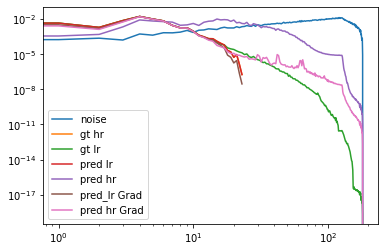

In [15]:
# compute spectrum
spec_ns = phy.energy_spectrum(torch.randn(*shape_hr).permute(2,0,1))[0]
spec_lr = phy.energy_spectrum(y_lr.view(*shape_lr).permute(2,0,1))[0]
spec_hr = phy.energy_spectrum(y_hr.view(*shape_hr).permute(2,0,1))[0]

spec_lr_pred_grad = phy.energy_spectrum(y_hat_lr_grad.view(*shape_lr).permute(2,0,1))[0]
spec_hr_pred_grad = phy.energy_spectrum(y_hat_hr_grad.view(*shape_hr).permute(2,0,1))[0]

spec_lr_pred_nograd = phy.energy_spectrum(y_hat_lr_nograd.view(*shape_lr).permute(2,0,1))[0]
spec_hr_pred_nograd = phy.energy_spectrum(y_hat_hr_nograd.view(*shape_hr).permute(2,0,1))[0]

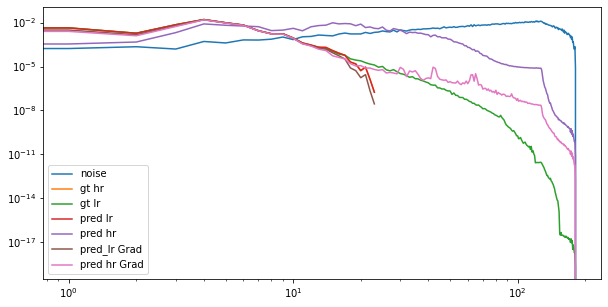

In [16]:
plt.figure(figsize=(10,5))
plt.loglog(spec_ns, label='noise')
plt.loglog(spec_lr, label='gt hr')
plt.loglog(spec_hr, label='gt lr')
plt.loglog(spec_lr_pred_nograd.detach(), label='pred lr')
plt.loglog(spec_hr_pred_nograd.detach(), label='pred hr')
plt.loglog(spec_lr_pred_grad.detach(), label='pred_lr Grad')
plt.loglog(spec_hr_pred_grad.detach(), label='pred hr Grad')
plt.legend()
plt.show()

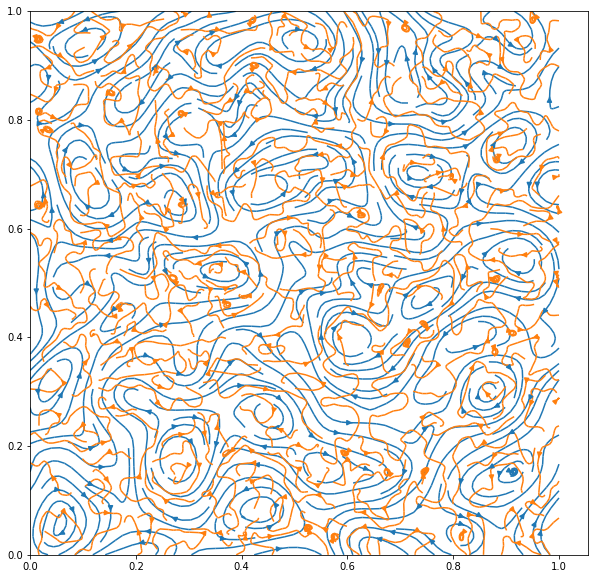

In [25]:
x = X_hr[:,0].detach()
y = X_hr[:,1].detach()
u = y_hat_hr_nograd[:,0].detach()
v = y_hat_hr_nograd[:,1].detach()


s = 1
plt.figure(figsize=(10,10))
plt.streamplot(        
           x.reshape(*img_shape_hr)[::s,::s].T.numpy(), 
           y.reshape(*img_shape_hr)[::s,::s].T.numpy(),
           y_hr[:,0].reshape(*img_shape_hr)[::s,::s].T.numpy(),
           y_hr[:,1].reshape(*img_shape_hr)[::s,::s].T.numpy(), density=2)
plt.streamplot(x.reshape(*img_shape_hr)[::s,::s].T.numpy(), 
           y.reshape(*img_shape_hr)[::s,::s].T.numpy(),
           u.reshape(*img_shape_hr)[::s,::s].T.numpy(),
           v.reshape(*img_shape_hr)[::s,::s].T.numpy(), density=2)

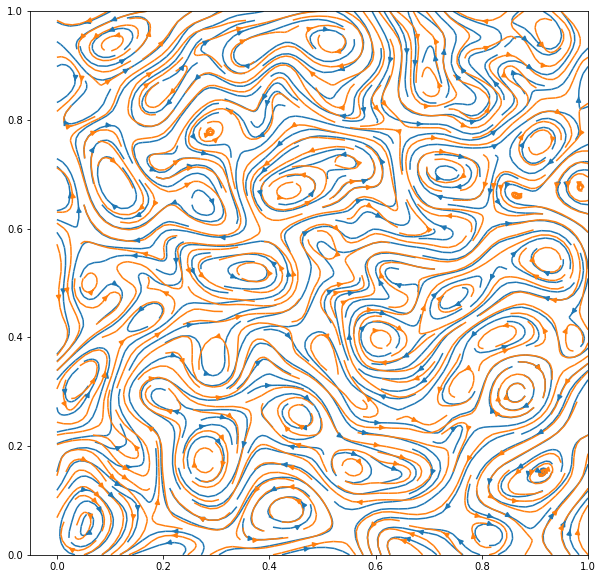

In [27]:
u = y_hat_hr_grad[:,0].detach()
v = y_hat_hr_grad[:,1].detach()

s = 1
plt.figure(figsize=(10,10))
plt.streamplot(        
           x.reshape(*img_shape_hr)[::s,::s].T.numpy(), 
           y.reshape(*img_shape_hr)[::s,::s].T.numpy(),
           y_hr[:,0].reshape(*img_shape_hr)[::s,::s].T.numpy(),
           y_hr[:,1].reshape(*img_shape_hr)[::s,::s].T.numpy(), density=2)
plt.streamplot(x.reshape(*img_shape_hr)[::s,::s].T.numpy(), 
           y.reshape(*img_shape_hr)[::s,::s].T.numpy(),
           u.reshape(*img_shape_hr)[::s,::s].T.numpy(),
           v.reshape(*img_shape_hr)[::s,::s].T.numpy(), density=2)

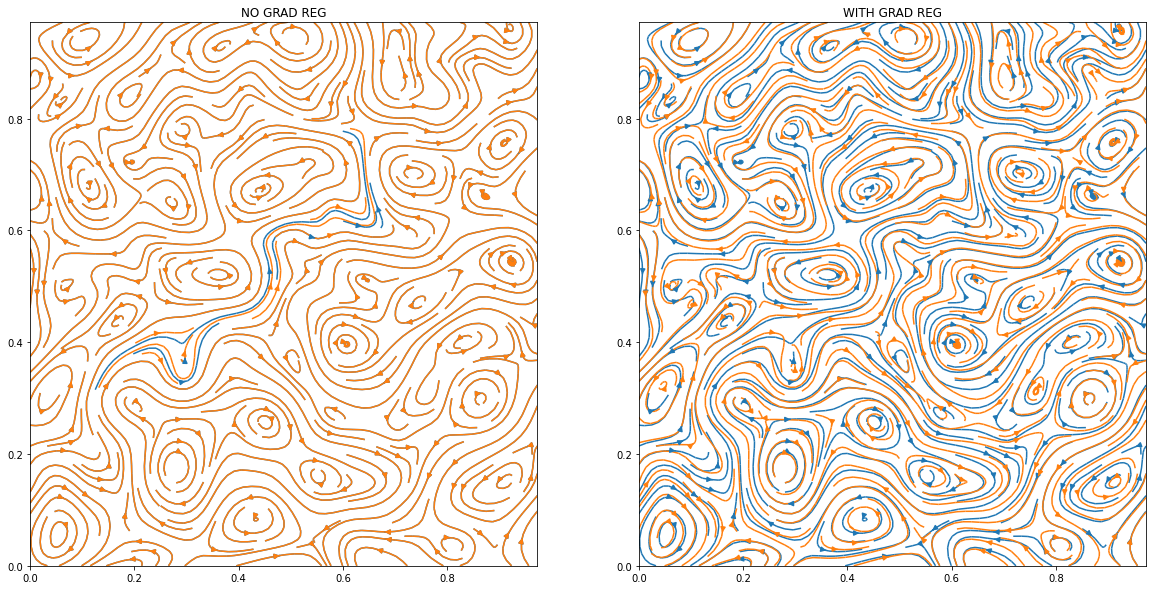

In [34]:
x = X_lr[:,0].detach()
y = X_lr[:,1].detach()
u = y_hat_lr_nograd[:,0].detach()
v = y_hat_lr_nograd[:,1].detach()

s = 1
plt.figure(figsize=(20,10))
plt.subplot(121)
plt.title('NO GRAD REG')
plt.streamplot(        
           x.reshape(*img_shape_lr)[::s,::s].T.numpy(), 
           y.reshape(*img_shape_lr)[::s,::s].T.numpy(),
           y_lr[:,0].reshape(*img_shape_lr)[::s,::s].T.numpy(),
           y_lr[:,1].reshape(*img_shape_lr)[::s,::s].T.numpy(), density=2)
plt.streamplot(
           x.reshape(*img_shape_lr)[::s,::s].T.numpy(), 
           y.reshape(*img_shape_lr)[::s,::s].T.numpy(),
           u.reshape(*img_shape_lr)[::s,::s].T.numpy(),
           v.reshape(*img_shape_lr)[::s,::s].T.numpy(), density=2)
plt.subplot(122)
plt.title('WITH GRAD REG')

x = X_lr[:,0].detach()
y = X_lr[:,1].detach()
u = y_hat_lr_grad[:,0].detach()
v = y_hat_lr_grad[:,1].detach()

plt.streamplot(        
           x.reshape(*img_shape_lr)[::s,::s].T.numpy(), 
           y.reshape(*img_shape_lr)[::s,::s].T.numpy(),
           y_lr[:,0].reshape(*img_shape_lr)[::s,::s].T.numpy(),
           y_lr[:,1].reshape(*img_shape_lr)[::s,::s].T.numpy(), density=2)
plt.streamplot(
           x.reshape(*img_shape_lr)[::s,::s].T.numpy(), 
           y.reshape(*img_shape_lr)[::s,::s].T.numpy(),
           u.reshape(*img_shape_lr)[::s,::s].T.numpy(),
           v.reshape(*img_shape_lr)[::s,::s].T.numpy(), density=2)